In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

sales = pd.read_csv('train.csv', parse_dates = [0], date_parser = parser)

In [3]:
sales = sales.set_index('date')
sales['month'] = sales.index.month
sales['year'] = sales.index.year
print(len(sales))
sales.head()

913000


,store,item,sales,month,year
date,,,,,
2013-01-01,1,1,13,1,2013
2013-01-02,1,1,11,1,2013
2013-01-03,1,1,14,1,2013
2013-01-04,1,1,13,1,2013
2013-01-05,1,1,10,1,2013


In [4]:
# Restructure Full Data Set

store_list = []
items_by_store = []
daily_sales_list = []
daily_diff_list = []
weekly_sales_list = []
weekly_diff_list = []
monthly_sales_list = []
monthly_diff_list = []

# Separate sales by store for the training set

for i in range(1, 11):
    store = sales[sales.store == i]
    store_list.append(store)
    
# Create a separate dataframe to store non-sales columns for each store in our list
    
for i in store_list:
    sales_items = i.drop(columns='sales')
    items_by_store.append(sales_items)

# Convert our time series to daily stationary for each store

for i in store_list:
    daily_sales = i.reset_index().resample('D', on='date').sum()
    daily_diff = daily_sales.sales.diff(periods = 1)
    daily_diff = pd.DataFrame(daily_diff)
    daily_diff = daily_diff[1:]
    daily_sales = pd.DataFrame(daily_sales.sales)
    daily_sales_list.append(daily_sales)
    daily_diff_list.append(daily_diff)
    
# Convert our time series to weekly stationary for each store

for i in store_list:
    weekly_sales = i.reset_index().resample('W', on='date').sum()
    weekly_diff = weekly_sales.sales.diff(periods = 1)
    weekly_diff = pd.DataFrame(weekly_diff)
    weekly_diff = weekly_diff[1:]
    weekly_sales = pd.DataFrame(weekly_sales.sales)
    weekly_sales = weekly_sales[1:]
    weekly_sales_list.append(weekly_sales)
    weekly_diff_list.append(weekly_diff)
    
    
# Convert our time series to monthly stationary for each store

for i in store_list:
    monthly_sales = i.reset_index().resample('M', on='date').sum()
    monthly_diff = monthly_sales.sales.diff(periods = 1)
    monthly_diff = pd.DataFrame(monthly_diff)
    monthly_diff = monthly_diff[1:]
    monthly_sales = pd.DataFrame(monthly_sales.sales)
    monthly_sales_list.append(monthly_sales)
    monthly_diff_list.append(monthly_diff)
    

In [5]:
store1_daily_sales = daily_sales_list[0]
print(len(store1_daily_sales))
store1_daily_sales.head()

1826


,sales
date,
2013-01-01,1316
2013-01-02,1264
2013-01-03,1305
2013-01-04,1452
2013-01-05,1499


In [6]:
store1_monthly_sales = monthly_sales_list[0]
print(len(store1_monthly_sales))
store1_monthly_sales.head()

60


,sales
date,
2013-01-31,41077
2013-02-28,41306
2013-03-31,55827
2013-04-30,61523
2013-05-31,69272


In [7]:
len(weekly_sales_list[0])

260

In [8]:
len(monthly_sales_list[0])

60

In [9]:
W = weekly_sales_list
weekly_sales_train_list = []
weekly_sales_test_list = []

for i in W:
    train_size = int(208)
    weekly_sales_train, weekly_sales_test = i[0:train_size], i[train_size:]
    weekly_sales_train = pd.DataFrame(weekly_sales_train.sales)
    weekly_sales_train_list.append(weekly_sales_train)
    weekly_sales_test = pd.DataFrame(weekly_sales_test.sales)
    weekly_sales_test_list.append(weekly_sales_test)
   

In [10]:
print(len(weekly_sales_list[0]))
print(len(weekly_sales_train_list[0]))
print(len(weekly_sales_test_list[0]))

260
208
52


In [11]:
M = monthly_sales_list
monthly_sales_train_list = []
monthly_sales_test_list = []

for i in M:
    train_size = int(48)
    monthly_sales_train, monthly_sales_test = i[0:train_size], i[train_size:]
    monthly_sales_train = pd.DataFrame(monthly_sales_train.sales)
    monthly_sales_train_list.append(monthly_sales_train)
    monthly_sales_test = pd.DataFrame(monthly_sales_test.sales)
    monthly_sales_test_list.append(monthly_sales_test)

In [12]:
print(len(monthly_sales_list[0]))
print(len(monthly_sales_train_list[0]))
print(len(monthly_sales_test_list[0]))

60
48
12


In [13]:
import copy 
from random import random
from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [14]:
# evaluate an ARIMA model for a given order (p,d,q)

def evaluate_arima_model(X, arima_order):
    
    # prepare historical dataset
        
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    
    predictions = list()
    for t in range(len(test)):
#         sarima = SARIMAX(history, order=arima_order)
#         sarima = sarima.fit(disp=0)
        arima = ARIMA(history, order=arima_order)
        arima = arima.fit(disp=0)
        yhat = arima.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # calculate out of sample error
    
    error = sqrt(mean_squared_error(test, predictions))
    return error

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import itertools

def evaluate_arima_models(data, p_values, d_values, q_values):

    global best_cfg

    data = data.astype('float32')
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))

    for i in pdq:
        try:
            rmse = evaluate_arima_model(data, i)
            if rmse < best_score:
                best_score, best_cfg = rmse, i
        except:
            continue
            
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [17]:
arima_monthly_sales_predictions_list = []
arima_rmse_list = []
arima_monthly_data = []


def arima_pipeline(monthly_sales_by_store, monthly_sales_train, monthly_sales_test):
    
    for i in range(len(monthly_sales_by_store)):
        
        print('Store {}:'.format(i+1))
        
        data = monthly_sales_by_store[i]
        train = monthly_sales_train[i]
        test = monthly_sales_test[i]
        
        p_range = range(0, 13)
        d_range = range(1, 2)
        q_range = range(0, 2)
        
        evaluate_arima_models(data.values, p_range, d_range, q_range)
        
        
        # Fit ARIMA Model

        if best_cfg[1] == 0:
            sarima = SARIMAX(train, order=best_cfg, enforce_stationarity=False)
            sarima = sarima.fit(disp=0)
        else:
            sarima = SARIMAX(train, order=best_cfg)
            sarima = sarima.fit(disp=0)

        # plot predictions

        predictions = sarima.forecast(12)
        arima_monthly_sales_predictions_list.append(predictions)

        error = sqrt(mean_squared_error(test, predictions))
        arima_rmse_list.append(error)


        data['forecast'] = sarima.forecast(12)  
#         data[['sales', 'forecast']].plot()
        arima_monthly_data.append(data)
    
    
        plt.figure(figsize=(15,8));
        plt.plot(train, label='Train Set')
        plt.plot(test, label='Test Set')
        plt.plot(predictions, label='Predictions')
        plt.legend(loc='upper left', prop={'size': 16});


Store 1:
Best ARIMA(7, 1, 0) RMSE=7078.019
Store 2:
Best ARIMA(7, 1, 0) RMSE=9380.938
Store 3:
Best ARIMA(7, 1, 0) RMSE=8403.955
Store 4:
Best ARIMA(7, 1, 0) RMSE=7513.392
Store 5:
Best ARIMA(7, 1, 0) RMSE=5729.279
Store 6:
Best ARIMA(7, 1, 0) RMSE=5695.294
Store 7:
Best ARIMA(7, 1, 0) RMSE=5422.087
Store 8:
Best ARIMA(7, 1, 0) RMSE=9266.468
Store 9:
Best ARIMA(7, 1, 0) RMSE=7878.058
Store 10:
Best ARIMA(7, 1, 0) RMSE=8436.030


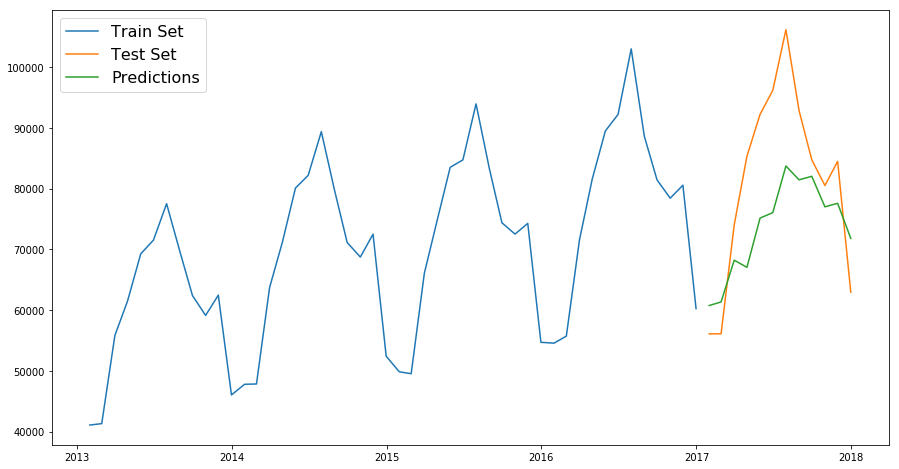

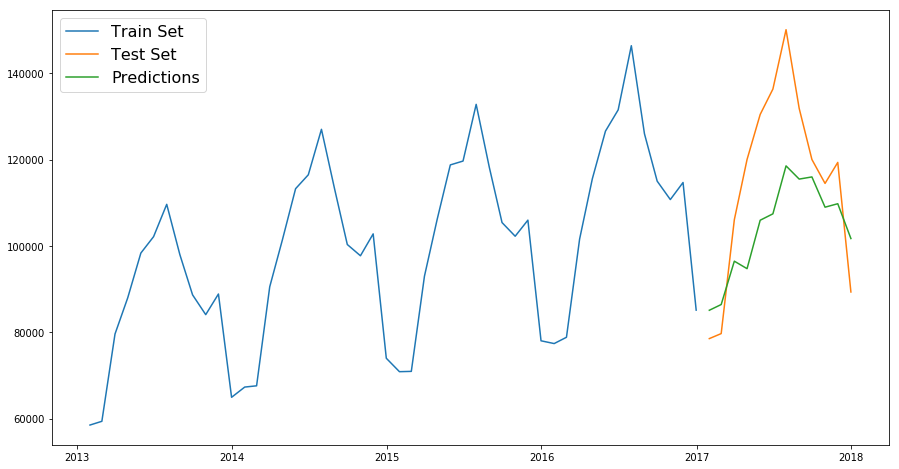

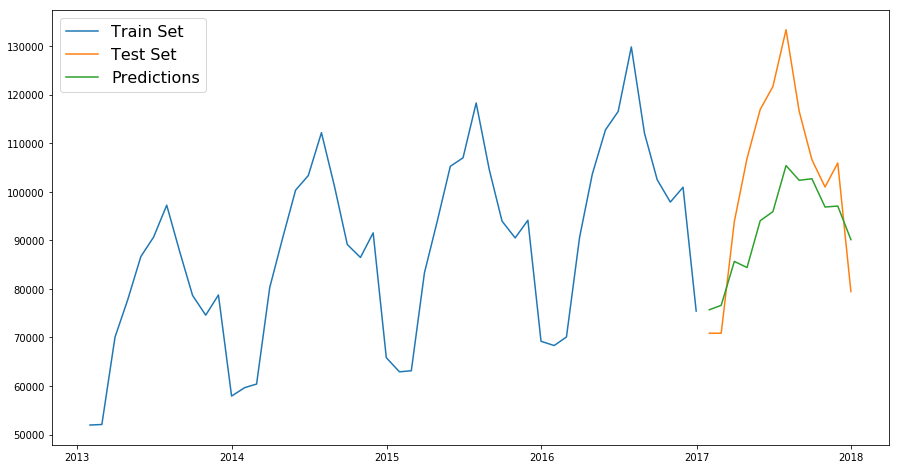

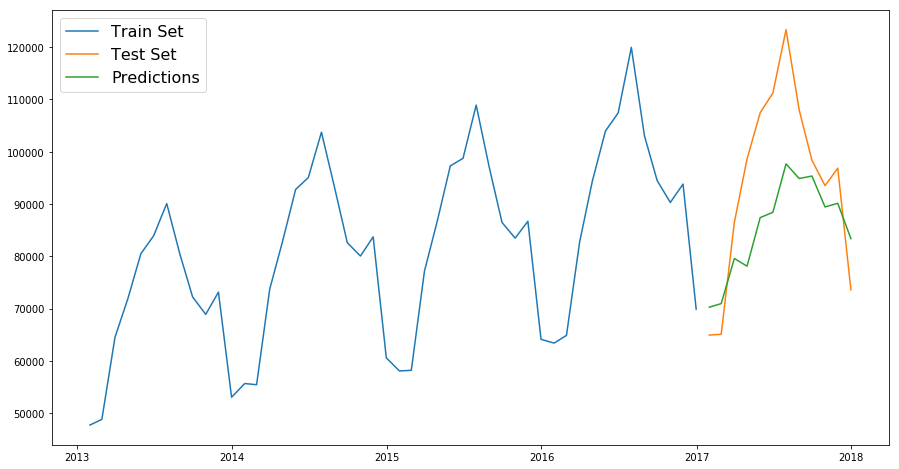

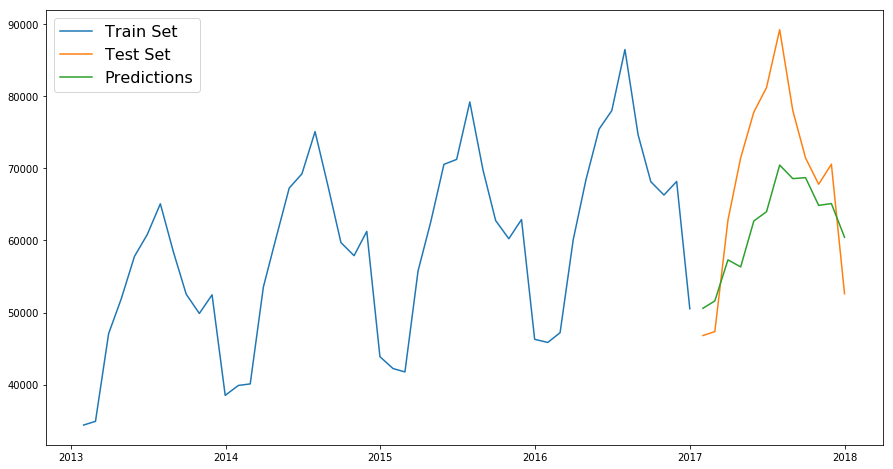

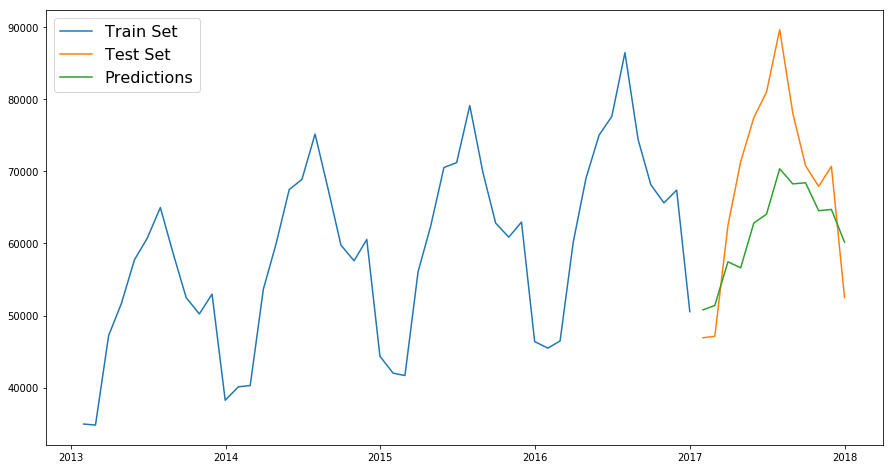

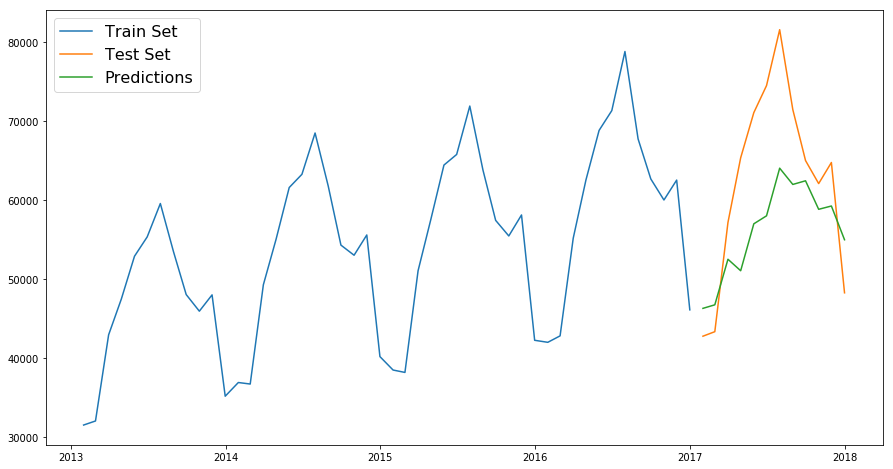

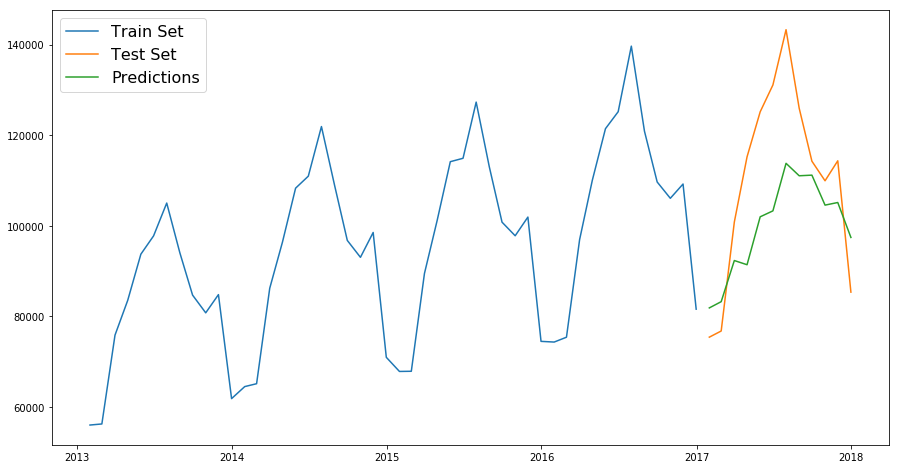

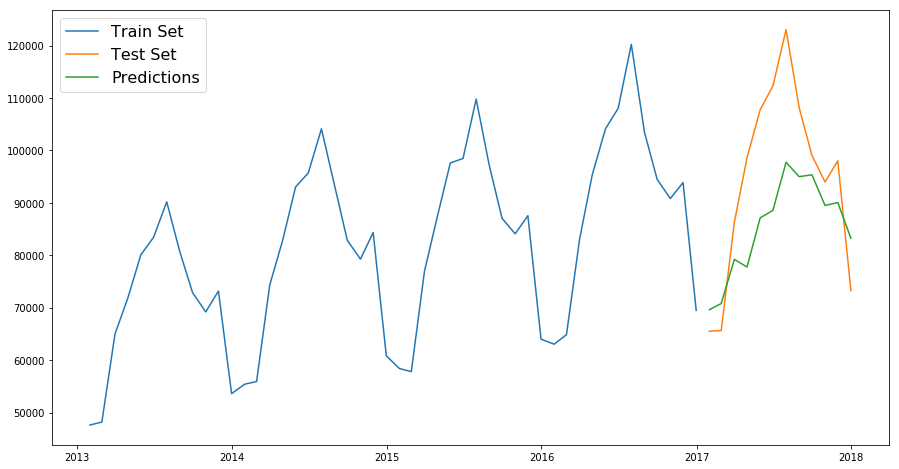

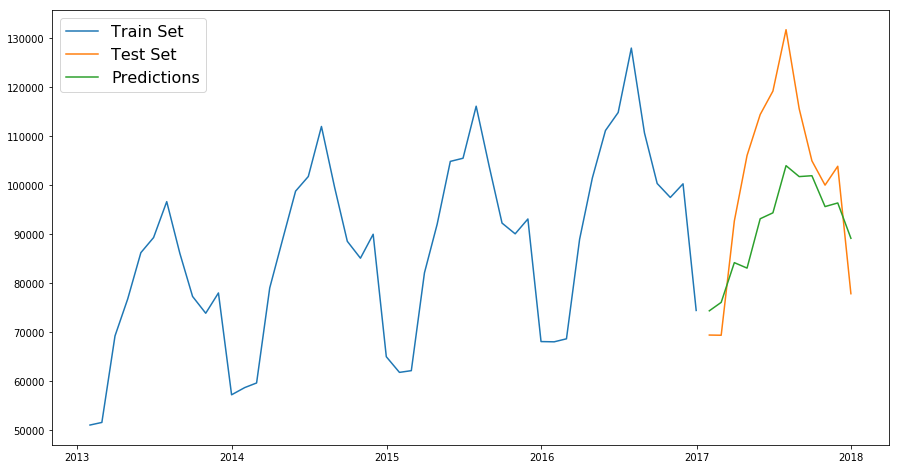

In [18]:
import warnings
warnings.filterwarnings("ignore")

arima_pipeline(monthly_sales_list, monthly_sales_train_list, monthly_sales_test_list)